# Model Evaluation for Text Generation

Evaluating our final supervised fine-tuned model

## Initializations

In [1]:
import os
import sys

# Run this only for colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install evaluate

In [ ]:
pip install trl

In [ ]:
pip install torchmetrics

Import the fine-tuned and reward model

In [5]:
import torch
import trl

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from generative_model import GenerativeModel

In [6]:
import trl
from reward_model import *
from generative_model import GenerativeModel
from utils import *

path = "/content/drive/MyDrive/Model"
fine_tuned_model = GenerativeModel(path,DEVICE)

In [8]:
from transformers import AutoModelForSequenceClassification

reward_model_path = "/content/drive/MyDrive/-Reward_Model"
reward_model = AutoModelForSequenceClassification.from_pretrained(
            reward_model_path).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(reward_model_path)

In [56]:
fine_tuned_model

In [9]:
reward_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [10]:
testing_dataset=get_supervised_data("/content/small_test.json")

In [12]:
import torch.nn.functional as F


def get_reward( demonstration):
  """
  Returns a number in the range [-0.5,0.5] which corresponds
  to the shifted probability of being positive.

  Args:
      demonstration: str
  Return:
      reward: Torch.Tensor
  """
  max_input_length=500
  rewards = []

  encoded_text = tokenizer.encode_plus(
      demonstration,
      add_special_tokens=True,
      return_tensors="pt",
      truncation=True,
      max_length=max_input_length,
      padding="max_length",
  ).to(DEVICE)


  logits = reward_model(**encoded_text).logits

  probs = F.softmax(logits,dim=1)[0][1] - 0.5

  return probs*2

In [35]:
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torch
import numpy as np

def evaluation(fine_tuned_model, reward_model, data):


    eval_step = 0  # Counter for the number of evaluation steps
    max_input_length=1024
    #fine_tuned_model.zero_grad()
    #fine_tuned_model.eval()  # Put the model in evaluation mode
    average_reward = []

    # Iterate through the validation dataset
    for pair in tqdm(data, desc="Testing"):
      # Unpack the batch into input_ids, attention_mask, and token_type_ids
      # input_ids, attention_mask, token_type_ids = batch
      question, answer = pair
      # Generate text based on the question
      generated_text = fine_tuned_model.generate(question)

      # Construct the complete dialogue string
      text = 'Human: ' + question + '\n\n Assistant: ' + generated_text

      # Get the reward for the generated text using the reward model
      reward = get_reward(text).item()
      print(reward)
      # Append the reward to the list of average rewards
      average_reward.append(reward)

    return average_reward


In [ ]:
#TESTING
average_reward= evaluation(
    fine_tuned_model,
    reward_model,
    testing_dataset,
)
testing_reward=average_reward

In [36]:
testing_dataset_prompts=get_supervised_data("/content/prompts.json")

In [ ]:
#TESTING
average_reward_prompts= evaluation(
    fine_tuned_model,
    reward_model,
    testing_dataset_prompts
)

In [40]:
prompt_mean=np.mean(average_reward_prompts)
prompt_mean

-0.04680428683757782

VISUALIZE

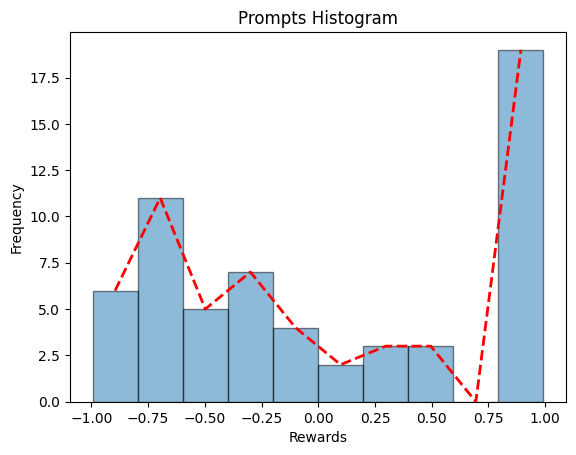

In [55]:
n, bins, patches = plt.hist(testing_reward, bins=10, edgecolor='black',alpha=0.5)
plt.xlabel('Rewards')
plt.ylabel('Frequency')
plt.title('Prompts Histogram')

# Calculate the midpoints of the bins
bin_midpoints = 0.5 * (bins[1:] + bins[:-1])

# Plotting the line graph
plt.plot(bin_midpoints, n, color='red', linestyle='dashed', linewidth=2)

plt.show()

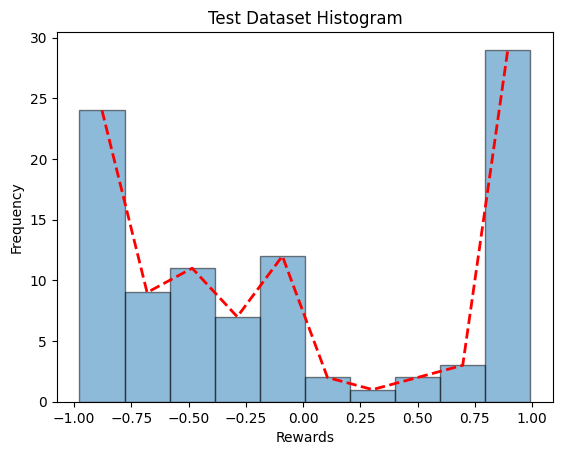

In [54]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(average_reward_prompts, bins=10, edgecolor='black',alpha=0.5)
plt.xlabel('Rewards')
plt.ylabel('Frequency')
plt.title('Test Dataset Histogram')

# Calculate the midpoints of the bins
bin_midpoints = 0.5 * (bins[1:] + bins[:-1])

# Plotting the line graph
plt.plot(bin_midpoints, n, color='red', linestyle='dashed', linewidth=2)

plt.show()